# Frequency-based Embeddings

## Count Vectorization (Bag of Words)

1. Tokenization: Split the text into individual words or tokens.
2. Vocabulary Creation: Create a list of all unique words (vocabulary) from the text corpus.
3. Vectorization: Convert each document into a vector of numbers where each number represents the count (or frequency) of a word in the document.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
corpus = [
    "Apple is a tech company.",
    "Apple is a red fruit with health benefits."
]

In [3]:
# corpus = [
#     "Welcome to UP, UP is a good place.",
#     "In the UP, AKTU is the best."
# ]

In [4]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer(lowercase=False) # disable automatic lowercasing

# Fit the model and transform the corpus into BoW vectors
X = vectorizer.fit_transform(corpus)

# Display the vocabulary and vectors
print("Vocabulary:", vectorizer.get_feature_names_out())

print("\nBag of Words (Document-Term Matrix):")
print("Vectors:\n", X.toarray())



#          Apple  benefits  company  fruit  health  is  red  tech  with
# sent1 =>   1      0         1       0       0     1    0    1     0
# sent2 =>   1      1         0       1       1     1    1    0     1


Vocabulary: ['Apple' 'benefits' 'company' 'fruit' 'health' 'is' 'red' 'tech' 'with']

Bag of Words (Document-Term Matrix):
Vectors:
 [[1 0 1 0 0 1 0 1 0]
 [1 1 0 1 1 1 1 0 1]]


## TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF adjusts the raw word count by considering the importance of words in the context of the entire corpus

* Term Frequency (TF): Measures how frequently a word appears in a document (sentence)
* Inverse Document Frequency (IDF): Measures how important a word is by considering how often it appears across all documents (sentences)

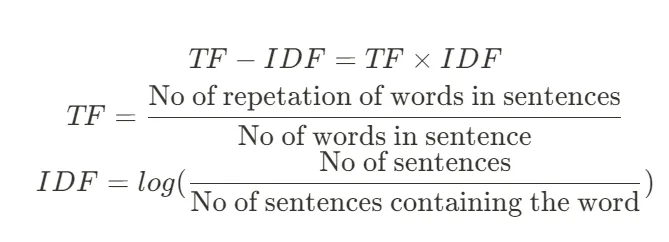

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# corpus = [
#     "Welcome to UP, UP is a good place.",
#     "In the UP, AKTU is the best."
# ]

In [7]:
corpus = [
    "Apple is a tech company.",
    "Apple is a red fruit with health benefits."
]

Vocabulary: ['Apple' 'benefits' 'company' 'fruit' 'health' 'is' 'red' 'tech' 'with']


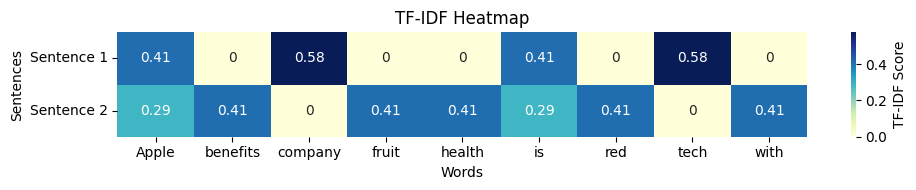

In [8]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(lowercase=False)
X = vectorizer.fit_transform(corpus)

# Get vocabulary
feature_names = vectorizer.get_feature_names_out()
print("Vocabulary:", feature_names)

# Convert the TF-IDF matrix to an array
tfidf_matrix = X.toarray()

# Create a DataFrame for easy visualization
df_tfidf = pd.DataFrame(tfidf_matrix, columns=feature_names, index=["Sentence 1", "Sentence 2"])

# Plot heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(df_tfidf, annot=True, cmap="YlGnBu", cbar_kws={'label': 'TF-IDF Score'})
plt.title("TF-IDF Heatmap")
plt.xlabel("Words")
plt.ylabel("Sentences")
plt.tight_layout()
plt.show()

## Co-occurrence Matrices

Represent words by their co-occurrence with other words within a specific context window. In a co-occurrence matrix, each cell `[i][j]` contains the number of times word `j` appears near word `i` within a given context window

* Define Context Window: Determine the window size around each word to consider its neighboring words.
* Count Co-occurrences: For each word pair within the context window, count how often they appear together.

In [9]:
import pandas as pd
from collections import defaultdict
import re

In [10]:
corpus = [
    "Apple is a tech company.",
    "Apple is a red fruit with health benefits."
]

In [11]:
# corpus = [
#     "Welcome to UP, UP is a good place.",
#     "In the UP, AKTU is the best."
# ]

In [12]:
# Tokenize (preserve casing, remove punctuation)
tokenized = [re.findall(r'\b\w+\b', doc) for doc in corpus]

# Flatten and build vocabulary
flat_tokens = [word for sentence in tokenized for word in sentence]
vocab = sorted(set(flat_tokens))

# Create word-index mapping
word2idx = {word: idx for idx, word in enumerate(vocab)}

# Initialize co-occurrence matrix
matrix_size = len(vocab)
co_matrix = [[0]*matrix_size for _ in range(matrix_size)]

# Populate the co-occurrence matrix (context window = 1)
for sentence in tokenized:
    for i, word in enumerate(sentence):
        word_idx = word2idx[word]
        for j in [i - 1, i + 1]:  # look at neighbors
            if 0 <= j < len(sentence):
                neighbor = sentence[j]
                neighbor_idx = word2idx[neighbor]
                co_matrix[word_idx][neighbor_idx] += 1

# Step 5: Convert to DataFrame for better readability
co_df = pd.DataFrame(co_matrix, index=vocab, columns=vocab)

print("Co-occurrence Matrix (Window size = 1):")
print(co_df)

Co-occurrence Matrix (Window size = 1):
          Apple  a  benefits  company  fruit  health  is  red  tech  with
Apple         0  0         0        0      0       0   2    0     0     0
a             0  0         0        0      0       0   2    1     1     0
benefits      0  0         0        0      0       1   0    0     0     0
company       0  0         0        0      0       0   0    0     1     0
fruit         0  0         0        0      0       0   0    1     0     1
health        0  0         1        0      0       0   0    0     0     1
is            2  2         0        0      0       0   0    0     0     0
red           0  1         0        0      1       0   0    0     0     0
tech          0  1         0        1      0       0   0    0     0     0
with          0  0         0        0      1       1   0    0     0     0


# Prediction-based Embeddings

## Word2Vec and Skip-Gram

In [13]:
!pip install gensim

In [29]:
from gensim.models import Word2Vec
import gensim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
import warnings
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [31]:
warnings.filterwarnings(action='ignore')

# Define corpus
corpus = [
    "Apple just announced their new MacBook Pro with M2 chip",
    "Apple's CEO Tim Cook revealed the new iPhone 15",
    "Apple stock rose 2% after WWDC keynote",
    "I ate a sweet red apple for breakfast",
    "The apple pie with cinnamon smelled delicious",
    "She packed an apple and some nuts in her lunchbox"
]

# Tokenize the corpus (convert each sentence to list of words)
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

# Create CBOW model
cbow_model = gensim.models.Word2Vec(
    tokenized_corpus,
    min_count=1,
    vector_size=10,
    window=5
)

# Create Skip Gram model
skipgram_model = gensim.models.Word2Vec(
    tokenized_corpus,
    min_count=1,
    vector_size=10,
    window=5,
    sg=1
)

# Print results
print("Cosine similarities using CBOW model:")
print("apple - macbook:", cbow_model.wv.similarity('apple', 'macbook'))
print("apple - delicious:", cbow_model.wv.similarity('apple', 'delicious'))
print("apple - breakfast:", cbow_model.wv.similarity('apple', 'breakfast'))
print("macbook - breakfast:", cbow_model.wv.similarity('macbook', 'breakfast'))

print("\nCosine similarities using Skip-gram model:")
print("apple - macbook:", skipgram_model.wv.similarity('apple', 'macbook'))
print("apple - delicious:", skipgram_model.wv.similarity('apple', 'delicious'))
print("apple - breakfast:", skipgram_model.wv.similarity('apple', 'breakfast'))
print("macbook - breakfast:", skipgram_model.wv.similarity('macbook', 'breakfast'))

Cosine similarities using CBOW model:
apple - macbook: 0.17408817
apple - delicious: 0.71498966
apple - breakfast: 0.41844964
macbook - breakfast: 0.11224465

Cosine similarities using Skip-gram model:
apple - macbook: 0.17479137
apple - delicious: 0.7153373
apple - breakfast: 0.4203251
macbook - breakfast: 0.1133752


## FastText

Similar to Word2Vec, but the model predicts the target word using the sum of its subword n-gram vectors

In [39]:
import re
from nltk.tokenize import word_tokenize
from gensim.models import FastText
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
corpus = [
    # 🍎 Apple as a Fruit
    "I ate a red apple with my breakfast.",
    "The apple pie had cinnamon and sugar.",
    "Green apples are sour but healthy.",
    "He picked fresh apples from the orchard.",
    "Apples are rich in vitamins and fiber.",
    "The teacher gave the student an apple.",
    "An apple a day keeps the doctor away.",

    # 💻 Apple as a Tech Company
    "Apple announced the new iPhone 15 with better cameras.",
    "Apple released the latest MacBook Pro with M3 chip.",
    "Tim Cook is the CEO of Apple Inc.",
    "Apple stock prices rose after the WWDC event.",
    "I use Apple Music and Apple Pay daily.",
    "Apple is known for its innovation in technology.",
    "She bought an iPad and an Apple Watch last week.",

    # 🥼 Ambiguous or shared context
    "The apple logo was shining on the back of the laptop.",
    "He bit into the apple while working on his MacBook.",
    "She made a fruit salad while watching the Apple event.",
]

In [51]:
# Preprocessing
tokenized_corpus = [word_tokenize(sent.lower()) for sent in corpus]

In [57]:
# Train FastText model
ft_model = FastText(sentences=tokenized_corpus, vector_size=10, window=3, min_count=1, sg=1, epochs=40)

# Print similar words
print("Most similar to 'apple':", ft_model.wv.most_similar("apple"))
print("Most similar to 'macbook':", ft_model.wv.most_similar("macbook"))

Most similar to 'apple': [('apples', 0.986577570438385), ('after', 0.9325563311576843), ('the', 0.9314371347427368), ('from', 0.9230853319168091), ('healthy', 0.9218953251838684), ('shining', 0.9080955982208252), ('breakfast', 0.9078802466392517), ('latest', 0.9060696959495544), ('bought', 0.8888440132141113), ('cook', 0.8869214653968811)]
Most similar to 'macbook': [('but', 0.8628860116004944), ('music', 0.8086134195327759), ('she', 0.8033251166343689), ('he', 0.7997745871543884), ('cook', 0.7883334755897522), ('after', 0.7879449129104614), ('.', 0.7487213611602783), ('last', 0.7460675835609436), ('ipad', 0.7417570352554321), ('shining', 0.737442672252655)]


# Contextualized word embeddings

* Context-Sensitive: Generates different embeddings for the same word based on its context.
* Pre-trained on Large Corpus: Can be fine-tuned for various NLP tasks, improving performance.

In [5]:
from transformers import AutoModel, AutoTokenizer
import torch

# Select GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load tokenizer and model (INSTRUCTOR is based on T5)
tokenizer = AutoTokenizer.from_pretrained("hkunlp/instructor-xl")
model = AutoModel.from_pretrained("hkunlp/instructor-xl").encoder.to(device)

# Prepare inputs: concatenate instruction + text
texts_with_instructions = [
    "Represent the Apple company for retrieval: Apple just released their new iPhone model.",
    "Represent the apple fruit for retrieval: I ate a juicy red apple for breakfast."
]

# Tokenize inputs
inputs = tokenizer(
    texts_with_instructions,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
).to(device)

# Get embeddings using mean pooling
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # [batch_size, hidden_dim]

# Cosine similarity
similarity = torch.nn.functional.cosine_similarity(
    embeddings[0].unsqueeze(0),
    embeddings[1].unsqueeze(0)
)

# Show results
print("\nEmbedding for Apple company (first 10 dims):", embeddings[0][:10])
print("Embedding for apple fruit (first 10 dims):", embeddings[1][:10])
print(f"\nCosine similarity between the two: {similarity.item():.4f}")

Using device: cuda


Some weights of T5Model were not initialized from the model checkpoint at hkunlp/instructor-xl and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder


Embedding for Apple company (first 10 dims): tensor([ 0.0285, -0.0078, -0.0463, -0.0513, -0.0283,  0.0374,  0.0211,  0.0327,
        -0.0326, -0.0700], device='cuda:0')
Embedding for apple fruit (first 10 dims): tensor([-0.0179,  0.0483, -0.0437,  0.0573, -0.0099,  0.0092,  0.0372,  0.0067,
         0.0424, -0.1328], device='cuda:0')

Cosine similarity between the two: 0.6384
